In [ ]:
# ==========================================
#  SETUP
# ==========================================
import pandas as pd
import timm                                # Library with many pretrained computer vision models
import torch                               # Core PyTorch library
import torch.nn as nn                      # Neural network modules (layers, losses, etc.)
import torch.optim as optim                # Optimization algorithms like Adam or SGD
from torchvision import datasets, transforms  # For loading and transforming image datasets
from torch.utils.data import DataLoader    # Efficiently loads data in mini-batches
import matplotlib.pyplot as plt            # For plotting accuracy/loss curves
import time                                # To measure training duration

# Check if GPU is available; otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)             # Displays which device is used


Using device: cuda


In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="0apuY54n6Ea1yF7wvKar")
project = rf.workspace("crisho").project("animals-1mc6n")
version = project.version(1)
dataset = version.download("folder")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 75.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 117.2 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to animals-1 in folder:: 100%|██████████| 3013/3013 [00:00<00:00, 5329.59it/s]


In [ ]:
# Define the main dataset directory that contains 'train' and 'val' folders
data_dir = "data"

# Define transformations for both training and validation sets
data_transforms = {
    "train": transforms.Compose([            # Training transformations
        transforms.Resize((224, 224)),       # Resize all images to 224x224 pixels
        transforms.RandomHorizontalFlip(),   # Randomly flip images horizontally (data augmentation)
        transforms.ToTensor(),               # Convert PIL Image to PyTorch tensor (values between 0 and 1)
    ]),
    "test": transforms.Compose([              # Validation transformations
        transforms.Resize((224, 224)),       # Resize validation images to 224x224 pixels
        transforms.ToTensor(),               # Convert to tensor (no random augmentation)
    ]),
}

# Load datasets from folders and apply corresponding transforms
image_datasets = {
    x: datasets.ImageFolder(root=f"{data_dir}/{x}", transform=data_transforms[x])
    for x in ["train", "test"]
}

# Create dataloaders to load data in batches and shuffle during training
dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=32, shuffle=True)
    for x in ["train", "test"]
}

# Extract class names (folder names) from training dataset
class_names = image_datasets["train"].classes
print("Classes:", class_names)              # Display detected classes


Classes: ['cats', 'dogs', 'snakes']


In [ ]:
# Define a function to train and validate the model
def train_model(model, criterion, optimizer,num_epochs ):
    since = time.time()                     # Start timer
    train_acc, val_acc = [], []             # Lists to store accuracy history

    # Loop over each epoch
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 30)

        # Each epoch has a training and validation phase
        for phase in ["train", "test"]:
            if phase == "train":
                model.train()               # Set model to training mode
            else:
                model.eval()                # Set model to evaluation mode

            running_loss, running_corrects = 0.0, 0   # Track loss and correct predictions

            # Iterate over batches of data
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU/CPU
                optimizer.zero_grad()          # Reset gradients before each batch

                # Enable gradients only during training phase
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)    # Forward pass through the network
                    loss = criterion(outputs, labels)   # Compute loss
                    _, preds = torch.max(outputs, 1)    # Get predicted class (highest score)

                    # Backpropagation and optimization only in training phase
                    if phase == "train":
                        loss.backward()        # Compute gradients
                        optimizer.step()       # Update model weights

                # Accumulate loss and correct predictions
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # Calculate accuracy for the epoch
            epoch_acc = running_corrects.double() / len(image_datasets[phase])
            print(f"{phase} Acc: {epoch_acc:.4f}")     # Display accuracy per phase

            # Save accuracy for plotting later
            if phase == "train":
                train_acc.append(epoch_acc.item())
            else:
                val_acc.append(epoch_acc.item())

    print("Training complete")               # Indicate completion
    return train_acc, val_acc                 # Return accuracy history for analysis



##  Benchmark: Comparing **Feature Extraction** vs **Fine-Tuning**

This section measures the **computational performance difference** between:
1. **Feature Extraction (Transfer Learning)** – where pretrained layers are frozen and only the classifier is trained.
2. **Fine-Tuning** – where selected deeper layers are unfrozen and trained along with the classifier.

We use the **same training function** (`train_model`) for both experiments to ensure fair comparison.



The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]


Epoch 1/10
------------------------------
train Acc: 0.8861
test Acc: 0.9700

Epoch 2/10
------------------------------
train Acc: 0.9657
test Acc: 0.9700

Epoch 3/10
------------------------------
train Acc: 0.9695
test Acc: 0.9667

Epoch 4/10
------------------------------
train Acc: 0.9724
test Acc: 0.9700

Epoch 5/10
------------------------------
train Acc: 0.9771
test Acc: 0.9733

Epoch 6/10
------------------------------
train Acc: 0.9786
test Acc: 0.9700

Epoch 7/10
------------------------------
train Acc: 0.9805
test Acc: 0.9700

Epoch 8/10
------------------------------
train Acc: 0.9833
test Acc: 0.9733

Epoch 9/10
------------------------------
train Acc: 0.9828
test Acc: 0.9700

Epoch 10/10
------------------------------
train Acc: 0.9790
test Acc: 0.9667
Training complete

Epoch 1/10
------------------------------
train Acc: 0.5288
test Acc: 0.7167

Epoch 2/10
------------------------------
train Acc: 0.8352
test Acc: 0.9200

Epoch 3/10
------------------------------
tr

,Experiment,Training Time (sec),Peak GPU Memory (MB),Final Validation Accuracy
0,Feature Extraction,182.169302,422.479980,0.966667
1,Fine-Tuning,185.104313,446.390137,0.983333


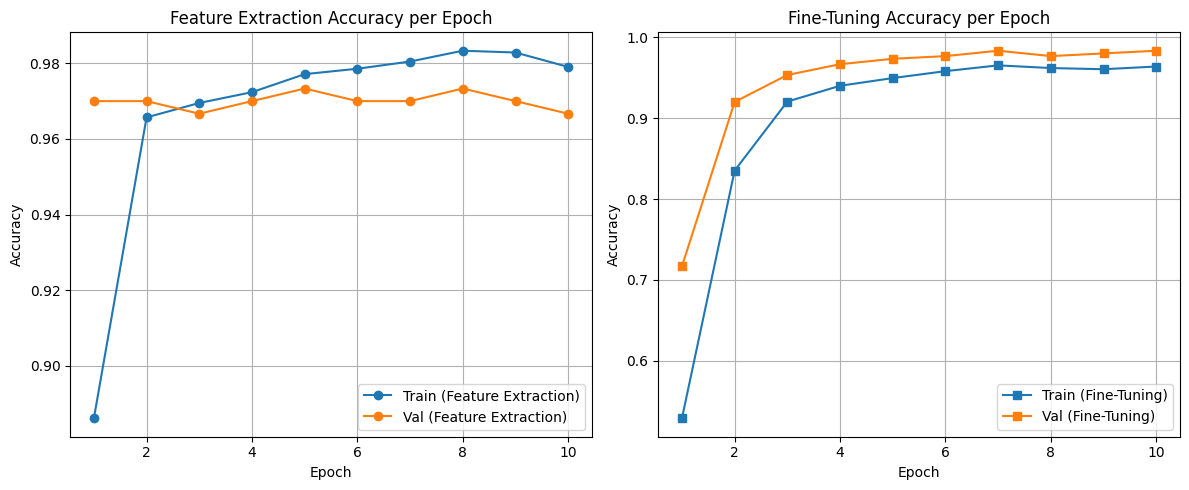

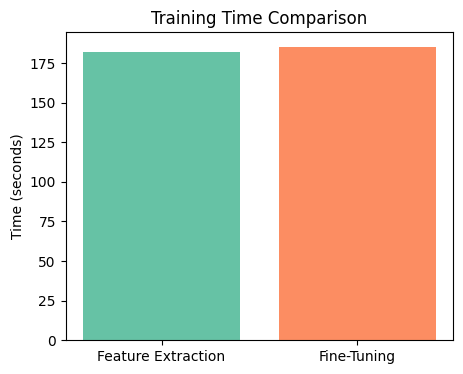

In [ ]:

# ==========================================
# BENCHMARK: FEATURE EXTRACTION vs FINE-TUNING
# ==========================================



# --------------------------------------------------
# Helper: Function to get GPU memory in MB
# --------------------------------------------------
def gpu_mem_mb():
    if torch.cuda.is_available():                           # Check if CUDA is available
        return torch.cuda.max_memory_allocated() / (1024**2) # Convert bytes to MB
    return None                                              # Return None if not on GPU

# --------------------------------------------------
# FEATURE EXTRACTION (Transfer Learning)
# --------------------------------------------------

# Recreate pretrained model (so both experiments start from identical weights)
model_fe = timm.create_model("efficientnet_b0", pretrained=True)
criterion = nn.CrossEntropyLoss()
NUM_EPOCHS = 10

# --------------------------------------------------
# Freeze all model parameters (prevents gradient updates on feature extractor)
for p in model_fe.parameters():
    p.requires_grad = False

# Replace classifier head for the correct number of output classes
num_features = model_fe.get_classifier().in_features
model_fe.classifier = torch.nn.Linear(num_features, len(class_names))

# Move model to GPU/CPU
model_fe = model_fe.to(device)

# Define optimizer for classifier only (since only those parameters are trainable)
opt_fe = torch.optim.Adam(filter(lambda p: p.requires_grad, model_fe.parameters()), lr=0.001)

# Reset CUDA peak memory tracking if GPU is used
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()

# Record start time for benchmarking
start_time = time.time()

# Train the model using the SAME training function
train_acc_fe, val_acc_fe = train_model(model_fe, criterion, opt_fe, NUM_EPOCHS)

# Compute elapsed training time
time_fe = time.time() - start_time

# Record peak GPU memory (if available)
peak_mem_fe = gpu_mem_mb()

# --------------------------------------------------
# FINE-TUNING (Unfreeze deeper layers)
# --------------------------------------------------

# Recreate another pretrained model to start from the same initial weights
model_ft = timm.create_model("efficientnet_b0", pretrained=True)

# Initially freeze all layers
for p in model_ft.parameters():
    p.requires_grad = False

# Replace classifier head with correct output size
num_features = model_ft.get_classifier().in_features
model_ft.classifier = torch.nn.Linear(num_features, len(class_names))

# Unfreeze selected deep layers (e.g., last block + classifier)
for name, p in model_ft.named_parameters():
    if ("blocks.6" in name) or ("conv_head" in name) or ("classifier" in name):
        p.requires_grad = True

# Move fine-tuning model to device
model_ft = model_ft.to(device)

# Define optimizer for all trainable layers (use smaller learning rate)
opt_ft = torch.optim.Adam(filter(lambda p: p.requires_grad, model_ft.parameters()), lr=1e-5)

# Reset GPU memory stats
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()

# Record time for fine-tuning phase
start_time = time.time()

# Train again using the SAME training function
train_acc_ft, val_acc_ft = train_model(model_ft, criterion, opt_ft, NUM_EPOCHS)

# Compute time and GPU memory usage
time_ft = time.time() - start_time
peak_mem_ft = gpu_mem_mb()

# --------------------------------------------------
# SUMMARIZE & VISUALIZE RESULTS
# --------------------------------------------------

print("=======================================")
print("Benchmark summary (same training loop used for both experiments):")
print(f"Feature extraction time: {time_fe:.2f} sec, Peak GPU memory: {peak_mem_fe if peak_mem_fe else 'N/A'} MB")
print(f"Fine-tuning time:        {time_ft:.2f} sec, Peak GPU memory: {peak_mem_ft if peak_mem_ft else 'N/A'} MB")
print("=======================================")

# Build summary DataFrame for better visualization
summary = pd.DataFrame({
    "Experiment": ["Feature Extraction", "Fine-Tuning"],
    "Training Time (sec)": [time_fe, time_ft],
    "Peak GPU Memory (MB)": [peak_mem_fe, peak_mem_ft],
    "Final Validation Accuracy": [val_acc_fe[-1], val_acc_ft[-1]]
})
display(summary)

# Plot accuracy curves for both experiments
epochs = list(range(1, NUM_EPOCHS + 1))
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc_fe, label="Train (Feature Extraction)", marker='o')
plt.plot(epochs, val_acc_fe, label="Val (Feature Extraction)", marker='o')
plt.title("Feature Extraction Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_ft, label="Train (Fine-Tuning)", marker='s')
plt.plot(epochs, val_acc_ft, label="Val (Fine-Tuning)", marker='s')
plt.title("Fine-Tuning Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Bar chart comparing training time between both methods
plt.figure(figsize=(5, 4))
plt.bar(["Feature Extraction", "Fine-Tuning"], [time_fe, time_ft], color=["#66c2a5", "#fc8d62"])
plt.title("Training Time Comparison")
plt.ylabel("Time (seconds)")
plt.show()


Classes: ['cats', 'dogs', 'snakes']
Extracting features...
Original feature shape: (2099, 512)

=== Without PCA ===
Validation Accuracy: 0.9833
Training Time: 4.78 seconds
Feature Dimension: 512

=== With PCA ===
Validation Accuracy: 0.9867
Training Time: 3.41 seconds
Feature Dimension: 223

Classification Report (PCA Model):
              precision    recall  f1-score   support

        cats       0.98      0.98      0.98       102
        dogs       0.98      0.98      0.98        98
      snakes       1.00      1.00      1.00       100

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



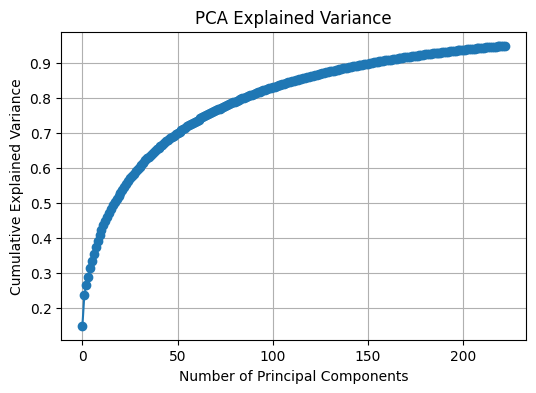


=== Comparison Summary ===
         Model  Accuracy  Training Time (s)  Feature Dimension
0  Without PCA  0.983333           4.779615                512
1     With PCA  0.986667           3.405159                223


In [ ]:
# ==========================================================
# FEATURE EXTRACTION WITH RESNET18 + PCA COMPARISON
# ==========================================================

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import os

# ----------------------------------------------------------
# 1. Set device and define transformations
# ----------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ----------------------------------------------------------
# 2. Load dataset
# ----------------------------------------------------------
data_dir = "data"  # Replace with your dataset path
train_dataset = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=transform)
val_dataset   = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)

class_names = train_dataset.classes
print("Classes:", class_names)

# ----------------------------------------------------------
# 3. Load pretrained ResNet18 and remove the final layer
# ----------------------------------------------------------
resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
resnet18 = resnet18.to(device)

feature_extractor = nn.Sequential(*list(resnet18.children())[:-1])  # Remove the final classification layer
feature_extractor.eval()  # Set model to evaluation mode

# ----------------------------------------------------------
# 4. Define feature extraction function
# ----------------------------------------------------------
def extract_features(dataloader):
    """Extract features and labels from images using the pretrained CNN."""
    features_list, labels_list = [], []

    with torch.no_grad():  # Disable gradient computation
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = feature_extractor(inputs)          # Forward pass
            outputs = outputs.view(outputs.size(0), -1)  # Flatten [batch, 512, 1, 1] → [batch, 512]
            features_list.append(outputs.cpu().numpy())  # Move to CPU and convert to NumPy
            labels_list.append(labels.cpu().numpy())

    # Concatenate all features and labels
    X = np.concatenate(features_list)
    y = np.concatenate(labels_list)
    return X, y

# ----------------------------------------------------------
# 5. Extract deep features
# ----------------------------------------------------------
print("Extracting features...")
X_train, y_train = extract_features(train_loader)
X_val, y_val = extract_features(val_loader)
print("Original feature shape:", X_train.shape)

# ----------------------------------------------------------
# 6. Train classifier WITHOUT PCA
# ----------------------------------------------------------
start_time = time.time()
clf_no_pca = RandomForestClassifier(n_estimators=100, random_state=42)
clf_no_pca.fit(X_train, y_train)
train_time_no_pca = time.time() - start_time

y_pred_no_pca = clf_no_pca.predict(X_val)
acc_no_pca = accuracy_score(y_val, y_pred_no_pca)

print("\n=== Without PCA ===")
print(f"Validation Accuracy: {acc_no_pca:.4f}")
print(f"Training Time: {train_time_no_pca:.2f} seconds")
print("Feature Dimension:", X_train.shape[1])

# ----------------------------------------------------------
# 7. Apply PCA and train classifier WITH PCA
# ----------------------------------------------------------
 # Number of components to retain
pca = PCA(n_components=0.95, random_state=42)

# Fit PCA on training features and apply to both sets
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)

start_time = time.time()
clf_pca = RandomForestClassifier(n_estimators=100, random_state=42)
clf_pca.fit(X_train_pca, y_train)
train_time_pca = time.time() - start_time

y_pred_pca = clf_pca.predict(X_val_pca)
acc_pca = accuracy_score(y_val, y_pred_pca)

print("\n=== With PCA ===")
print(f"Validation Accuracy: {acc_pca:.4f}")
print(f"Training Time: {train_time_pca:.2f} seconds")
print("Feature Dimension:", X_train_pca.shape[1])

# ----------------------------------------------------------
# 8. Print classification report for PCA model
# ----------------------------------------------------------
print("\nClassification Report (PCA Model):")
print(classification_report(y_val, y_pred_pca, target_names=class_names))

# ----------------------------------------------------------
# 9. Visualize the explained variance of PCA
# ----------------------------------------------------------
plt.figure(figsize=(6, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.show()

# ----------------------------------------------------------
# 10. Compare results in a summary table
# ----------------------------------------------------------
import pandas as pd

comparison = pd.DataFrame({
    "Model": ["Without PCA", "With PCA"],
    "Accuracy": [acc_no_pca, acc_pca],
    "Training Time (s)": [train_time_no_pca, train_time_pca],
    "Feature Dimension": [X_train.shape[1], X_train_pca.shape[1]]
})

print("\n=== Comparison Summary ===")
print(comparison)
